In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyspark --quiet

     |████████████████████████████████| 281.3 MB 44 kB/s 
     |████████████████████████████████| 199 kB 71.1 MB/s 


In [3]:
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

In [4]:
conf = SparkConf().setAppName("AThang")
sc = SparkContext.getOrCreate(conf=conf)
spark = SparkSession(sc)
spark

In [5]:
import pickle
with open('/content/drive/MyDrive/dataset/lupus_single_cell_clustered.pkl', 'rb') as f:
  data = pickle.load(f)

In [6]:
import pandas as pd
data.to_csv('data.csv')

In [7]:
dataset = spark.read.option('header','true').csv('data.csv') 

In [8]:
from pyspark.sql.types import FloatType, IntegerType
for col in dataset.columns:
  dataset = dataset.withColumn(col, dataset[col].cast(FloatType()))

dataset = dataset.withColumn("_c0", dataset["_c0"].cast(IntegerType()))
dataset = dataset.withColumn("Label", dataset["Label"].cast(IntegerType()))

dataset = dataset.drop("_c0", "Label")

In [9]:
from pyspark.ml.feature import VectorAssembler
feat_cols = [col for col in dataset.columns]
featureassembler=VectorAssembler(inputCols=feat_cols,outputCol="features")
final_data=featureassembler.transform(dataset)

In [10]:
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scalerModel = scaler.fit(final_data)
cluster_final_data = scalerModel.transform(final_data)

In [11]:
cluster_final_data.show()

+-------------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+-----------+-----------+-----------+-----------+---------------+-----------+-----------+----------+----------+-----------+----------+-----------+-----------+------------+-------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+--------------------+--------------------+
|         CD45| CD196_CCR6|CD181_CXCR1|     HLA_DR|       CD15|CD31_PECAM1|       CD8a| CD182_CXCR2|         IgA|    CD66ace|       CD63|       CD14|      CD66b|CD62L_Lselectin|        CD3|       CD27|      CD86|      CD10| CD197_CCR7|      CD28|      CD11c|       CD33|       CD161|       CD45RO|       CD24|       CD38| CD278_ICOS|       CD32|CD152_CTLA4|        IgM|CD184_CXCR4|  CD279_PD1|       CD56|        CD16|            features|      scaledFeatures|
+-------------+-----------+-----------+-----------+-----------+-----------+---

In [12]:
from pyspark.ml.clustering import BisectingKMeans

# Loads data.
#dataset = spark.read.format("libsvm").load("data/mllib/sample_kmeans_data.txt")

# Trains a bisecting k-means model.
bkm = BisectingKMeans().setK(3).setSeed(1)
model = bkm.fit(cluster_final_data)



In [13]:
# Evaluate clustering.
from pyspark.ml.evaluation import ClusteringEvaluator
predictions = model.transform(cluster_final_data)
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Within Set Sum of Squared Errors = " + str(silhouette))



Within Set Sum of Squared Errors = 0.15787791590689457


In [14]:
# Shows the result.
print("Cluster Centers: ")
centers = model.clusterCenters()
for center in centers:
    print(center)

Cluster Centers: 
[-0.20695206 -0.14469204 -0.39111776 -0.40554289 -0.44194423 -0.63220646
 -0.03839438 -0.47815889 -0.49645935 -0.43295236 -0.5720881  -0.39232453
 -0.37261212 -0.04900746  0.28446326  0.23238354 -0.39644621 -0.45330098
  0.00997205  0.11467876 -0.7347637  -0.68964389 -0.21562222 -0.4816026
 -0.5049357  -0.35854214  0.18208361 -0.70732536 -0.13728046 -0.23329762
 -0.19486975 -0.03226477  0.03928751 -0.29008849]
[ 6.85031551e-02 -6.12076876e-02 -6.27209144e-04  7.74853368e-01
  1.89508624e-01  7.89905904e-01 -2.66141899e-02  7.12731739e-02
  3.09141619e-01 -2.02043470e-01  8.78529651e-01  1.09359990e+00
 -2.46443751e-01 -3.22224233e-01 -5.60821989e-01 -4.77525711e-01
  1.03408098e+00 -2.48978827e-01 -2.92210575e-01 -4.62766937e-01
  8.86190285e-01  9.73391958e-01  2.36762495e-01  2.88782192e-01
  7.87387227e-02  5.01734787e-01 -4.01174135e-01  6.52941643e-01
  1.38434591e-02 -4.09163576e-02  3.60358692e-01 -2.66581578e-01
 -5.93479357e-02 -2.88418881e-01]
[ 0.24302605  

In [15]:
predictions

DataFrame[CD45: float, CD196_CCR6: float, CD181_CXCR1: float, HLA_DR: float, CD15: float, CD31_PECAM1: float, CD8a: float, CD182_CXCR2: float, IgA: float, CD66ace: float, CD63: float, CD14: float, CD66b: float, CD62L_Lselectin: float, CD3: float, CD27: float, CD86: float, CD10: float, CD197_CCR7: float, CD28: float, CD11c: float, CD33: float, CD161: float, CD45RO: float, CD24: float, CD38: float, CD278_ICOS: float, CD32: float, CD152_CTLA4: float, IgM: float, CD184_CXCR4: float, CD279_PD1: float, CD56: float, CD16: float, features: vector, scaledFeatures: vector, prediction: int]

In [16]:
predictions.show()

+-------------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+-----------+-----------+-----------+-----------+---------------+-----------+-----------+----------+----------+-----------+----------+-----------+-----------+------------+-------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+--------------------+--------------------+----------+
|         CD45| CD196_CCR6|CD181_CXCR1|     HLA_DR|       CD15|CD31_PECAM1|       CD8a| CD182_CXCR2|         IgA|    CD66ace|       CD63|       CD14|      CD66b|CD62L_Lselectin|        CD3|       CD27|      CD86|      CD10| CD197_CCR7|      CD28|      CD11c|       CD33|       CD161|       CD45RO|       CD24|       CD38| CD278_ICOS|       CD32|CD152_CTLA4|        IgM|CD184_CXCR4|  CD279_PD1|       CD56|        CD16|            features|      scaledFeatures|prediction|
+-------------+-----------+-----------+-----------+-----

In [34]:
predictions.groupBy('prediction').count().show()

+----------+--------+
|prediction|   count|
+----------+--------+
|         1| 5269830|
|         2| 8689818|
|         0|11941920|
+----------+--------+



In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [18]:
pandasDF = predictions


In [20]:
pandasDF = pandasDF.drop("features", "scaledFeatures")
pandasDF.show()

+-------------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+-----------+-----------+-----------+-----------+---------------+-----------+-----------+----------+----------+-----------+----------+-----------+-----------+------------+-------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+----------+
|         CD45| CD196_CCR6|CD181_CXCR1|     HLA_DR|       CD15|CD31_PECAM1|       CD8a| CD182_CXCR2|         IgA|    CD66ace|       CD63|       CD14|      CD66b|CD62L_Lselectin|        CD3|       CD27|      CD86|      CD10| CD197_CCR7|      CD28|      CD11c|       CD33|       CD161|       CD45RO|       CD24|       CD38| CD278_ICOS|       CD32|CD152_CTLA4|        IgM|CD184_CXCR4|  CD279_PD1|       CD56|        CD16|prediction|
+-------------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+-----------+-----------+---

In [26]:
cluster_assignment = np.array(predictions.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)


In [27]:
cluster_assignment

array([[2],
       [2],
       [0],
       ...,
       [1],
       [0],
       [0]])

In [28]:
IgA = np.array(predictions.rdd.map(lambda row: row.IgA).collect()).reshape(-1,1)

In [29]:
IgM = np.array(predictions.rdd.map(lambda row: row.IgM).collect()).reshape(-1,1)

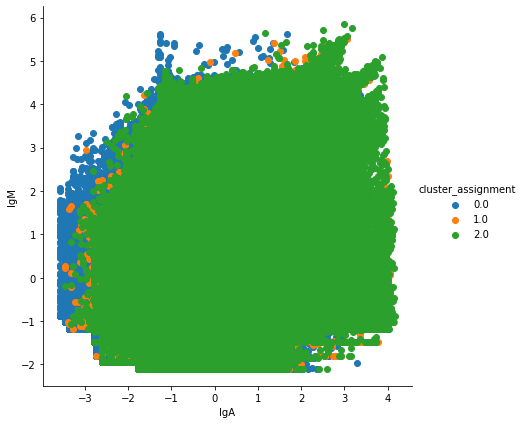

In [30]:
data = np.hstack((IgA, IgM, cluster_assignment))
cluster_df = pd.DataFrame(data=data, columns=("IgA", "IgM","cluster_assignment"))
sns.FacetGrid(cluster_df,hue="cluster_assignment", height=6).map(plt.scatter, 'IgA', 'IgM').add_legend()
plt.show()

In [35]:
cluster_df.head()

,IgA,IgM,cluster_assignment
0,0.974499,-0.752690,2.0
1,1.279445,-0.302479,2.0
2,0.496856,-0.752690,0.0
3,1.170881,-0.752690,1.0
4,-0.459735,-0.752690,1.0


In [37]:
dataset1 = spark.read.option('header','true').csv('data.csv') 

In [38]:
from pyspark.sql.types import FloatType, IntegerType
for col in dataset1.columns:
  dataset1 = dataset1.withColumn(col, dataset1[col].cast(FloatType()))

dataset1 = dataset1.withColumn("_c0", dataset1["_c0"].cast(IntegerType()))
dataset1 = dataset1.withColumn("Label", dataset1["Label"].cast(IntegerType()))

In [39]:
_c0 = np.array(dataset1.rdd.map(lambda row: row._c0).collect()).reshape(-1,1)

In [40]:
data2 = np.hstack((_c0 ,IgA, IgM, cluster_assignment))
cluster_df2 = pd.DataFrame(data=data2, columns=("_c0", "IgA", "IgM","cluster_assignment"))
cluster_df2.to_csv('final2.csv')

In [41]:
cluster_df2.head()

,_c0,IgA,IgM,cluster_assignment
0,0.0,0.974499,-0.752690,2.0
1,3.0,1.279445,-0.302479,2.0
2,5.0,0.496856,-0.752690,0.0
3,6.0,1.170881,-0.752690,1.0
4,7.0,-0.459735,-0.752690,1.0
